# Computer Lab: Séparateurs à Vaste Marge 

## Students: Frank FACUNDO, Lei TAN

**SD-TSIA 211**


Import of libraries:

In [1]:
import breastcancerutils as bcu
import numpy as np
import numpy.linalg as linear
import matplotlib.pyplot as plt
import scipy.optimize
import scipy.sparse
import scipy.sparse.linalg
import random
import math
import time

## Question 1 - Import data

We will work with a file called wdbcM1B0.data which contains information about breast cancer. It contains some characteristics $X_i$ and tags $Y$. To get the data of this .csv file, we will use the functions provided by the mentors. They are on the file **breastcancerutils.py**. In this first step, we will import the data and the libraries to make this Lab.

Import data :

In [2]:
import numpy as np

def load_breastcancer(filename):
    """
    Cette fonction lit le fichier filename, par exemple
    filename = 'wdbc_M1_B0.data'
    Elle retourne 
    X : une matrice de caracteristiques
    y : un vecteur des classes tel que si y[i] = 1, la tumeur est maligne
        et si y[i] = -1, la tumeur est benigne

    Pour plus d'infos sur la base de donnees,
    https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+%28Prognostic%29
    """

    data = np.loadtxt(filename, delimiter=',')

    # la colonne 0 ne nous interesse pas ici
    y = data[:, 1] * 2 - 1
    X = data[:, 2:]

    # Standardisation de la matrice
    X = X - np.mean(X, axis=0)
    X = X / np.std(X, axis=0)

    return X, y


In [3]:
X, y = load_breastcancer("wdbcM1B0.data")

In [4]:
print(np.shape(X))
print(np.shape(y))

(569, 30)
(569,)


## Question 2 - Subgradient method

Given the problem: $$\min _{ v\in \mathbb{R}^{ m },a\in \mathbb{R},\xi \in \mathbb{R}^{ n } }{ \frac { 1 }{ 2 } \sum _{ j=1 }^{ m }{ v^{ 2 }_{ j } } +c\sum _{ i=1 }^{ n }{ \xi _{ i } }  } \qquad (1)$$

With $\xi_i \ge 0, \forall i \in \{1,..,n\}$ and $\xi_i \ge 1-y_i(x_i^T v + a), \forall i \in \{1,..,n\}$.

### Question 2.1
The problem (1) can be written as : 
$$\min _{ v\in \mathbb{R}^{ m },a\in \mathbb{R} }{ \min _{ \xi \in \mathbb{R}^{ n } }{ \frac { 1 }{ 2 } \sum _{ j=1 }^{ m }{ v^{ 2 }_{ j } } +c\sum _{ i=1 }^{ n }{ \xi _{ i } }  }  } $$

The first part $\frac { 1 }{ 2 } \sum _{ j=1 }^{ m }{ v^{ 2 }_{ j } } $ does not depend on $\xi$, so we can focus on solving this problem : 

$\min _{ \xi \in \mathbb{R}^{ n } }{ c\sum _{ i=1 }^{ n }{ \xi _{ i } }  } $

According the (1) each $\xi_i$ have to respect $\xi_i \ge 0$ and $\xi_i \ge 1-y_i(x_i^T v + a)$. So, each $\xi _{ i }\ge \max { \left( 0,1-y_{ i }(x_{ i }^{ T }v+a) \right)  } $. As all $\xi_i$ and $\max { \left( 0,1-y_{ i }(x_{ i }^{ T }v+a) \right)  }$ are positive, this inequality holds:

$$\sum _{ i=1 }^{ n }{ \xi _{ i } } \ge \sum _{ i=1 }^{ n }{ \max { \left( 0,1-y_{ i }(x_{ i }^{ T }v+a) \right)  }  }$$

As each $\xi_i \in \mathbb{R}$, the minimum of each $\xi_i$ is reached in  $\max { \left( 0,1-y_{ i }(x_{ i }^{ T }v+a) \right)  }$. Therefore, $\min _{ \xi \in \mathbb{R}^{ n } }{ c\sum _{ i=1 }^{ n }{ \xi _{ i } }  } = c\sum _{ i=1 }^{ n }{ \max { \left( 0,1-y_{ i }(x_{ i }^{ T }v+a) \right)  }  }$ 

And (1) is equivalent to :

$$\min _{ v\in \mathbb{R}^{ m },a\in \mathbb{R} }{ \frac { 1 }{ 2 } \sum _{ j=1 }^{ m }{ v^{ 2 }_{ j } } +c\sum _{ i=1 }^{ n }{ \max { \left( 0,1-y_{ i }(x_{ i }^{ T }v+a) \right)  }  }  } \qquad (2) $$


### Question 2.2

$\partial h(z)=\begin{cases} \{ -1\} ; \quad z<1 \\ [-1;0];\quad z=1 \\ \{ 0\} ;\quad z>1 \end{cases}$

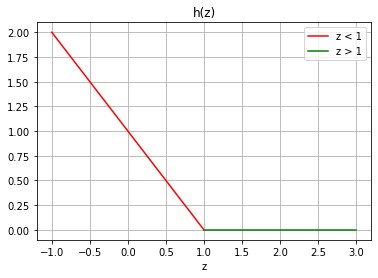

In [5]:
x1 = np.linspace(-1,1,10)
x2 = np.linspace(1,3,10)
plt.plot(x1, 1 - x1,'r', label = "z < 1")
plt.plot(x2,0*x2,'g', label = "z > 1")

plt.title("h(z)")
plt.xlabel("z")
plt.legend()
plt.grid()
plt.show()

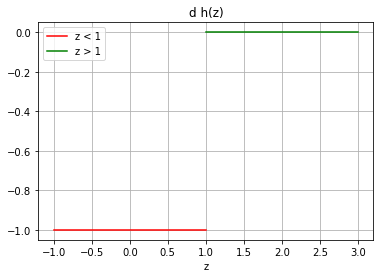

In [6]:
x1 = np.linspace(-1,1,10)
x2 = np.linspace(1,3,10)
y1 = np.linspace(-1,-1,10)
plt.plot(x1, y1,'r', label = "z < 1")
plt.plot(x2,0*x2,'g', label = "z > 1")

plt.title("d h(z)")
plt.xlabel("z")
plt.legend()
plt.grid()
plt.show()

### Question 2.3
Let 
$$f\left( v,a \right)=\frac { 1 }{ 2 } \sum _{ j=1 }^{ m }{ v^{ 2 }_{ j } } +c\sum _{ i=1 }^{ n }{ \max { \left( 0,1-y_{ i }(x_{ i }^{ T }v+a) \right)  }  }  $$

Let $$N(v,a) = \frac { 1 }{ 2 }\sum _{ j=1 }^{ m }{ v^{ 2 }_{ j } } + 0a^2 = \frac { 1 }{ 2 } \sum _{ j=1 }^{ m + 1}{ \overset{\sim }{v} ^{ 2 }_{ j } } = \frac { 1 }{ 2 } \overset{\sim }{v}^T\overset{\sim }{v}$$ 

with $\overset{\sim }{v} = \{v_1,v_2,...,v_j,0\}$

Let us show that $N(v,a)$ is separable

Let 
$$\psi_i(v) = \frac { 1 }{ 2 }v^2 \qquad \text{where }v\in \mathbb{R}$$
$$N(v,a)=\sum _{ j=1 }^{ m + 1}{ \psi_i(\overset{\sim }{v}_j) }$$

Let 

$$H(x) = \sum _{ i=1 }^{ n }{ \max { \left( 0,1-x_i \right)  }  }$$

Let $\phi_i(x_i)=max(0,1-x_i)$. It is clear that $H(x) = \sum _{ i=1 }^{ n }{\phi_i(x_i)}$ So $H(x)$ is separable

Let 
$$M(v,a) = Diag(Y)\overset{\sim }{X}\left( \begin{matrix} v \\ a \end{matrix} \right) $$ 
where $\overset{\sim }{X}=\left( x_1,x_2,..,x_m,\mathbb{1}  \right) $, $Y=(y_1,...,y_n)$, $x_i$ is a column vector of $X$. $\mathbb{1}$ is a column vector composed of n elements. All of them are 1. Then $M = Y\overset{\sim }{X}$

Then on demontre la derivé au-dessous :

$$\partial f(v,a) = \partial(N(v,a)+cH(M(v,a))) = \partial N(v,a) + cM(v,a)^T\partial H(M(v,a))$$

As $N(v,a)$ is separable and each $\psi_i(v) $ is differentiable, then

$$\partial N(v,a) = (\nabla\psi_1(v_1),\nabla\psi_2(v_2),...,\nabla\psi_{m}(v_{m}),\nabla\psi_{m+1}(a))^T = (v_1,v_2,...,v_n,0)^T$$

For $\partial H(M(v,a))$, we procede likewise as it is separable. So

$$\partial H(M(v,a)) = \left(\partial\phi_1(M_1(v,a)),\partial\phi_2(M_2(v,a)),..,\partial\phi_n(M_n(v,a))\right)^T$$

where $\phi_i(M_i(v,a)) \begin{cases} \{ -1\} ; \quad\quad M_i(v,a)<1 \\ [-1;0];\quad M_i(v,a)=1 \\ \{ 0\} ;\quad\quad M_i(v,a)>1 \end{cases}$ 

and $M_i(v,a)$ is the *i-th* coordinate of the vector $M_i(v,a)$.


### Question 2.4

Cette fonction retourne la valeur de la fonction $f(v,a)$ et un de ses sous-gradient en tout point. On utilisera la base de données $diabeticRetinopathy$ et c = 1.

In [7]:
dims = np.shape(X)
n = dims[0]
m = dims[1]
c = 1

a = 0
v = np.zeros(m)

In [8]:
"""
This returns the operator M (M_constant), this is a matrix of size n x (m+1)
"""
def M_matrix(X):    
    X_extended = np.ones((n,m+1))
    X_extended[:,:-1] = X
    M_matrix = np.diag(y)@X_extended
    return M_matrix

In [9]:
M_constant = M_matrix(X)

In [10]:
def M(v,a):
    v_a = np.append(v,a)
    M = M_constant@v_a
    return M

In [11]:
"""
This is each component of H before compute the somme.
it means a vector of size n with a function max(0, 1-xi) 
"""
def Hi(M):
    return np.maximum( np.zeros(np.shape(M)) , 1-M )

In [12]:
def H(Hi):
    h = np.sum ( Hi )
    return h

In [13]:
def N(v):
    v_extended = np.append(v,0)
    N = 0.5*np.dot(v_extended,v_extended)
    return N

In [14]:
def f(v,a,c):
    f_ = N(v) + c*H( Hi( M(v,a) ) )
    return f_

In [15]:
def gradN(v):
    return np.append(v,0)

In [16]:
def subgradientH(v,a):
    M_ = M(v,a)
    subgradient_h = []
    for item in M_:
        if item < 1:
            subgradient_h.append(-1)
        elif item > 1:
            subgradient_h.append(0)
        else:
            subgradient_h.append(np.random.uniform(-1,0))
    
    subgradient_H =  (M_constant.T) @ subgradient_h
    return subgradient_H

In [17]:
def subgradientF(v,a,c):
    return gradN(v) + c*subgradientH(v,a)

In [18]:
subgradientF(v,a,c)

array([-401.67227502, -228.44097367, -408.60883936, -390.09318973,
       -197.28489321, -328.22148127, -383.14721063, -427.3041985 ,
       -181.84509798,    7.0634352 , -312.04525371,    4.56861423,
       -305.99668108, -301.64736575,   36.873181  , -161.21243374,
       -139.60579724, -224.51080955,    3.58836467,  -42.90155493,
       -427.21613038, -251.39455908, -430.77071337, -403.76117734,
       -231.89607933, -325.17580208, -362.92710448, -436.63153222,
       -229.05116772, -178.19917556,  145.        ])

### Question 2.5

Méthode du sous-gradient avec condition initiale (v, a) = 0.

In [19]:
def subGradientMethod(v,a,c=1,step=1000):
    v_k = v
    a_k = a
    gamma = 1/(step+1)
    for i in range(step-1):
        g_k = subgradientF(v_k,a_k,c)
        v_k1 = v_k - gamma*g_k[0:np.size(g_k)-1]
        a_k1 = a_k - gamma*g_k[np.size(g_k)-1]
        v_k = v_k1
        a_k = a_k1
        #To check the convergence: print(f(v_k1,a_k1,c))
    
    return f(v_k1,a_k1,c)

In [20]:
step = 1000
a = 0
v = np.zeros(m)
start_time = time.time()
optimal_value = subGradientMethod(v,a,c,step)
timelapse = time.time() - start_time
print("The optimized value of f is: ",optimal_value)
print("The time taken for 1000 iterations is : ",timelapse, "seconds.")

The optimized value of f is:  26.755323494551583
The time taken for 1000 iterations is :  0.6983604431152344 seconds.


In [21]:
ite = 500
liste=[]
for i in range(ite):
    optimal_value = subGradientMethod(v,a,c,i+2)
    liste.append(optimal_value)

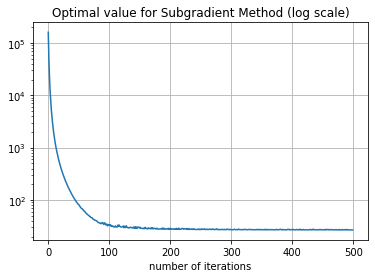

In [22]:
plt.plot(liste)
plt.yscale('log')
plt.title('Optimal value for Subgradient Method (log scale)')
plt.xlabel('number of iterations')
plt.grid(True)

## Question 3 - Méthode du sous-gradient stochastique

Let $$f_i\left( v,a \right)=\frac { 1 }{ 2 } \sum _{ j=1 }^{ m }{ v^{ 2 }_{ j } } +cn\max { \left( 0,1-y_{ i }(x_{ i }^{ T }v+a) \right) } $$

### Question 3.1

Let I a random variable which follows an uniform distribution over $\{1,...,n\}$. Let us find $\mathbb{E}[f_I(v,a)]$

$$\mathbb{E}[f_I(v,a)] = \sum _{ i=1 }^{ n }{ f_{ i }(v,a) \mathbb{P}(I=i) } = \sum _{ i=1 }^{ n }{ \frac1nf_{ i }(v,a)}$$ because I follows an uniform distribution.

So $$\mathbb{E}[f_I(v,a)] = \sum _{ i=1 }^{ n }{ \frac1n \left(\frac { 1 }{ 2 } \sum _{ j=1 }^{ m }{ v^{ 2 }_{ j } } +cn\max { \left( 0,1-y_{ i }\left(x_{ i }^{ T }v+a\right) \right) }\right)} = \frac { 1 }{ 2 } \sum _{ j=1 }^{ m }{ v^{ 2 }_{ j } } +c\sum _{ i=1 }^{ n }{ \max { \left( 0,1-y_{ i }(x_{ i }^{ T }v+a) \right)  }  } = f(v,a)$$

### Question 3.2

Using the same procedure as in the previous exercise, $f_i(v,a)$ can be decomposed in two functions:

$$f_i(v,a) = N(v,a) + cn \psi(M_i(v,a))$$ 

with $N(v,a)$ as previously defined, 
$ \psi(x)$  is the 

$$ \max { \left( 0,1-M_i(v,a) \right)  }$$ 

and $M_i(v,a)$ is the *i=th* component of $M(v,a)$

Then 

$$\partial f_i(v,a) = \partial N(v,a) + cnM^T_i\partial\psi_i(M_i(v,a)) $$

$$= (v_1,....,v_m,0)^T + cnM^T_i\partial\psi_i(M_i(v,a))$$ 

with $\partial\psi(x)$ as defined above and $M_i$ the *i-th* line of M (before the tranpose).

### Question 3.3 - Method stochastic subgradient

In [23]:
def subgradientHi(v,a,Ik):
    Mi_ = M_constant[Ik]
    Mi = np.dot(Mi_, np.append(v,a))
    if Mi < 1:
        subgradient_h = -1
    elif Mi > 1:
        subgradient_h = 0
    else:
        subgradient_h = np.random.uniform(-1,0)
    
    subgradient_H =  (Mi_.T) * subgradient_h
    return subgradient_H

In [24]:
def subgradientFi(v,a,c, Ik):
    return gradN(v) + c*n*subgradientHi(v,a, Ik)

In [25]:
def subGradientStochasticMethod(v,a,c=1,step=1000):
    v_k = v
    a_k = a
    gamma = 1/(step+1)
    for i in range(step-1):
        Ik = np.random.randint(n)
        g_k = subgradientFi(v_k,a_k,c, Ik)
        v_k1 = v_k - gamma*g_k[0:np.size(g_k)-1]
        a_k1 = a_k - gamma*g_k[np.size(g_k)-1]
        v_k = v_k1
        a_k = a_k1
        #To check the convergence: print(f(v_k1,a_k1,c))
    
    return f(v_k1,a_k1,c)

In [26]:
step = 100000
a = 0
v = np.zeros(m)
start_time = time.time()
subGradientStochasticMethod(v,a,c,step)
timelapse = time.time() - start_time
print("The optimized value of f is: ",optimal_value)
print("The time taken for 100000 iterations is : ",timelapse, "seconds.")

The optimized value of f is:  26.83268202073277
The time taken for 100000 iterations is :  2.450812816619873 seconds.


In [27]:
ite = 1000
liste=[]
for i in range(ite):
    optimal_value = subGradientStochasticMethod(v,a,c,i+2)
    liste.append(optimal_value)

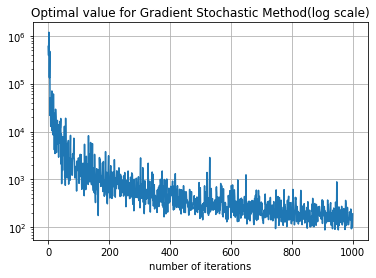

In [28]:
plt.plot(liste)
plt.yscale('log')
plt.title('Optimal value for Gradient Stochastic Method(log scale)')
plt.xlabel('number of iterations')
plt.grid(True)

## Question 4 - Méthode du lagrangien augmenté

### Question 4.1
Give the Lagrangien of the problem 1.

$$L\left( v,a,\xi,\varphi,\psi \right)=\frac { 1 }{ 2 } \sum _{ j=1 }^{ m }{ v^{ 2 }_{ j } } +c\sum _{ i=1 }^{ n }{ \xi_i  } +\sum _{ i=1 }^{ n }{ -\varphi_i\xi_i  } +\sum _{ i=1 }^{ n }{ -\psi_i(-\xi_i+1-y_i(x_i^Tv+a))} - l_{R_+^n}(\varphi) - l_{R_+^n}(\psi)$$

### Question 4.2
Demonstrate that:
$$ ∇_x g(x, \varphi) = \rho max(0, x + \frac{\varphi}{\rho} )$$
$$ ∇_\varphi g(x, \varphi) = max(-\frac{\varphi}{\rho}, x)$$

Regardless of the points on which the function is not differentiable, in another word, where $0= x + \frac{\varphi}{\rho}$,
$$ ∇_x g(x, \varphi) = \frac{\rho}{2} \frac{d(max(0, x + \frac{\varphi}{\rho} ))^2}{dx}$$
If $0 > x + \frac{\varphi}{\rho}$:  $$∇_x g(x, \varphi) =0$$  
If $0 < x + \frac{\varphi}{\rho}$:   
$$∇_x g(x, \varphi) =\frac{\rho}{2} \frac{d(x + \frac{\varphi}{\rho} )^2}{dx} =\rho(x + \frac{\varphi}{\rho} )$$
To write in a simpler way, $$ ∇_x g(x, \varphi) = \rho max(0, x + \frac{\varphi}{\rho} )$$
By using the same method,
$$∇_\varphi g(x, \varphi) =-\frac{\varphi}{\rho}+\rho max(0,x+\frac{\varphi}{\rho})\frac{d(max(0, x + \frac{\varphi}{\rho} ))}{dx}$$
If $0 > x + \frac{\varphi}{\rho}$:  $$∇_\varphi g(x, \varphi) =-\frac{\varphi}{\rho}$$  
If $0 < x + \frac{\varphi}{\rho}$:   
$$∇_x g(x, \varphi) =-\frac{\varphi}{\rho}+(x+\frac{\varphi}{\rho})=x$$
To write in a simpler way, $$ ∇_\varphi g(x, \varphi) = max(-\frac{\varphi}{\rho}, x)$$

### Question 4.3
Demonstrate that  $(x\rightarrow g(x, \varphi))$ is convex and $(\varphi\rightarrow g(x, \varphi))$ is concave.

Regardless of the points on which the function is not differentiable, in another word, where $0= x + \frac{\varphi}{\rho}$, we try to demonstrate the partial derivative of second degree of the original function is positive/negetive. This leads to directly the convexity/concavity of the original function. 

$$ ∇_x^2 g(x, \varphi) =\frac{d\rho max(0, x + \frac{\varphi}{\rho} )}{dx}$$
If $0 > x + \frac{\varphi}{\rho}$:  $$∇_x^2 g(x, \varphi) =0$$  
If $0 < x + \frac{\varphi}{\rho}$:   
$$∇_x^2 g(x, \varphi) =\rho$$
So, we have $ ∇_x^2 g(x, \varphi)$ positive,  $(x\rightarrow g(x, \varphi))$ is convex.  

$$ ∇_\varphi^2 g(x, \varphi) =\frac{dmax(-\frac{\varphi}{\rho}, x)}{d\varphi}$$
If $0 > x + \frac{\varphi}{\rho}$:  $$∇_x^2 g(x, \varphi) =-\frac{1}{\rho}$$  
If $0 < x + \frac{\varphi}{\rho}$:   
$$∇\varphi^2 g(x, \varphi) =0$$
So, we have $ ∇_\varphi^2 g(x, \varphi)$ negative,  $(x\rightarrow g(x, \varphi))$ is concave.  

### Question 4.4

In [29]:
def grad_va(p0,q0,va,e,p):
    va_tmp = va.copy()
    va_tmp[len(va)-1]=0
    return va_tmp - M_constant.T @ (p * np.maximum(0, (- e + 1 - M_constant @ va) + q0 / p))

In [30]:
def grad_e(p0,q0,va,e,p):
    return 1 - (p * np.maximum(0, -e + p0 / p)) - (p * np.maximum(0, (- e + 1 - M_constant @ va) + q0 / p))

In [31]:
def grad_method(p0,q0,err=1,p=2):
    
    grad = err+1
    va=np.zeros(m+1)
    e=np.zeros(n)
    # count = 1
    
    while grad >= err:
        
        #gamma = 1/(count+1)
        gamma = 0.001
        gva = grad_va(p0,q0,va,e,p)
        ge = grad_e(p0,q0,va,e,p)
        va_tmp = va - gamma * gva
        e_tmp = e - gamma * ge
        va=va_tmp
        e=e_tmp
        
        grad = math.sqrt(np.linalg.norm(gva)**2+np.linalg.norm(ge)**2)
        
    return va,e

### Question 4.5

In [32]:
def grad_phi(va,e,phi,psi,p):
    return  np.maximum(- phi / p, -e)

In [33]:
def grad_psi(va,e,phi,psi,p):
    return np.maximum(- psi / p, - e + 1 - M_constant @ va)

In [34]:
def grad_phi_psi(va,e,phi,psi,p=2):
    return grad_phi(va,e,phi,psi,p),grad_psi(va,e,phi,psi,p)

### Question 4.6

In [35]:
def lagragien_augmente(phi,psi,ite=100,p=2):
    liste=[]
    for i in range(ite):
        va,e = grad_method(phi,psi)
        phi = grad_phi_psi(va,e,phi,psi)[0]*p+phi
        psi = grad_phi_psi(va,e,phi,psi)[1]*p+psi
        result = 1/2 * np.linalg.norm(va[:-1]) ** 2 + sum(e)
        liste.append(result)
    return result,liste

The optimisation result after 100 iterations is:

In [36]:
phi = np.zeros(n)
psi = np.zeros(n)
result = lagragien_augmente(phi,psi)
print(result[0])

27.02378390430974


We can find that the result is quite close to the optimal result after 10 iterations according to the following graph. Here, we don't calculate 2000 iterations because the result doesn't greatly change after 10 iterations and the total runtime is estimated to be 1000 seconds = more than 10 minutes, which is not necessary for this exercise.

Text(0, 0.5, 'optimisation result')

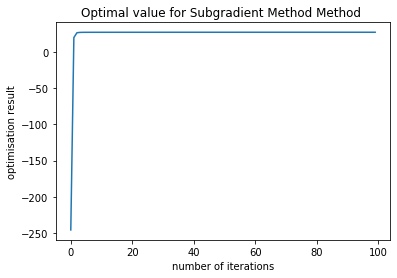

In [37]:
plt.plot(result[1])
plt.title('Optimal value for Subgradient Method Method ')
plt.xlabel('number of iterations')
plt.ylabel('optimisation result')

Text(0, 0.5, 'optimisation result')

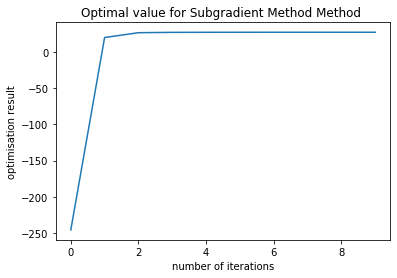

In [38]:
plt.plot(result[1][0:10])
plt.title('Optimal value for Subgradient Method Method ')
plt.xlabel('number of iterations')
plt.ylabel('optimisation result')

## Question 5 - Comparaison

The method of gradient descent obtains a good result with a small number of iterations. But as it takes the whole dataset into consideration during each iteration, it needs more calcul. 

The method of stochastic subgradient descent instead needs much more iterations to have the same precision that gradient descent. In practise, we even choose 100,000 as number of iterations to obtian a good result. But for each iteration, the input is just an observation, which greatly reduces the calcul compared with the method of gradient descent. 

The increased lagrangien uses totally a different way to solve the problem. Only with about 10 iterations, we can already obtain a good optimisation result. But, as we need to solve an optimisation problem in each iteration, an iteration takes about 0,5 seconds, much longer than the runtime the first two methods take.

